# Import and preparation

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gc
from keras import backend as K 
from tqdm.notebook import tqdm
%matplotlib widget

In [3]:
# create new file to write to (overwrites existing files)

with open("federated_stats.pkl","wb") as f:
    pickle.dump({},f)

In [5]:
# multithreading (should be activated per default, but just in case)
tf.config.threading.set_intra_op_parallelism_threads(16)

# Load  and process data

In [5]:
# load data
with open("AllData.pkl","rb") as f:
    data = pickle.load(f)

In [6]:
# create training, validation and test data splits

airfoil_sets = []
j=-1
for i in range(6,30):
    if (i-6)%4==0:
        j+=1
        airfoil_sets.append([])
    airfoil_sets[j].append(i)
airfoil_sets = np.array(airfoil_sets)

def process_data(airfoils):
    x = []
    x_phys_ext = []
    x_phys = []
    y = []
    for airfoil in airfoils:
        for i in range(len(data[airfoil]["alpha"])):
            x.append(np.reshape(data[airfoil]["coords_reduced"],-1))
            x_phys_ext.append([data[airfoil]["alpha"][i],data[airfoil]["Cl_approx_exp"][i],data[airfoil]["Cd_approx_exp"][i]])
            x_phys.append([data[airfoil]["alpha"][i],data[airfoil]["Cl_approx"][i],data[airfoil]["Cd_approx"][i]])
            y.append([data[airfoil]["Cl_target"][i], data[airfoil]["Cd_target"][i]])
    x = np.array(x)
    x_phys_ext = np.array(x_phys_ext)
    x_phys = np.array(x_phys)
    y = np.array(y)
    return [x, x_phys_ext, y]


data_sets_train = []
for i in range(airfoil_sets.shape[0]):
    data_sets_train.append(process_data([airfoil_sets[i,0], airfoil_sets[i,1]]))
data_sets_val = []
for i in range(airfoil_sets.shape[0]):
    data_sets_val.append(process_data([airfoil_sets[i,2]]))
data_sets_test = []
for i in range(airfoil_sets.shape[0]):
    data_sets_test.append(process_data([ airfoil_sets[i,3]]))
    
af_train = []
for i in range(len(airfoil_sets)):
    af_train.append(airfoil_sets[i,0])
    af_train.append(airfoil_sets[i,1])
a_train = process_data(af_train)
x_train, x_train_phys, y_train = a_train[0], a_train[1], a_train[2]
af_val = []
for i in range(len(airfoil_sets)):
    af_val.append(airfoil_sets[i,2])
a_val = process_data(af_val)
x_val, x_val_phys, y_val = a_val[0], a_val[1], a_val[2]
af_test = []
for i in range(len(airfoil_sets)):
    af_test.append(airfoil_sets[i,3])
a_test = process_data(af_test)
x_test, x_test_phys, y_test = a_test[0], a_test[1], a_test[2]

# Define training functions

In [8]:
# function for trtaining single nn federated
def train_nn_federated(mode,
                       train,
                       val,
                         verbose,
                       aggregation_steps = 1000,
                       epochs=200,  
                       federated="FedAvg",
                       batch_size=64,
                       collection="epoch",
                       local_lr=0.01,
                       global_lr=0.01,
                         ):
    #print(collection)
    def build_nn(optimizer="adam"):
        # build NN
        inputs = tf.keras.layers.Input(40,)
        if "PGNN" in mode:
            phys = tf.keras.layers.Input(3,)
            inputs2 = inputs
        elif mode == "DDNN":
            phys = tf.keras.layers.Input(1,)
            inputs2 = tf.keras.layers.Concatenate()([inputs,phys])

        hidden_nodes = 200


        if mode == "PGNN_1":
            merged = tf.keras.layers.Concatenate()([inputs2,phys])
            h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(inputs2)

        if mode == "PGNN_2":
            merged = tf.keras.layers.Concatenate()([h1,phys])
            h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(h1)

        if mode == "PGNN_3":
            merged = tf.keras.layers.Concatenate()([h2,phys])
            h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(h2)


        if mode == "PGNN_4":
            merged = tf.keras.layers.Concatenate()([h3,phys])
            h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(h3)

        if mode == "PGNN_5":
            merged = tf.keras.layers.Concatenate()([h4,phys])
            h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(h4)    

        if mode == "PGNN_6":
            merged = tf.keras.layers.Concatenate()([h5,phys])
            h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(merged)
        else:
            h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                       bias_initializer=tf.keras.initializers.Zeros()
                                      )(h5)  

        outputs = tf.keras.layers.Dense(2, activation=None, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h6)
        model = tf.keras.Model(inputs=[inputs,phys],outputs = outputs)


        # compiel NN
        if optimizer=="adam":
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=local_lr),
                #ptimizer=tf.keras.optimizers.SGD(learning_rate=local_lr),
                loss = "mse", 
            )
        elif optimizer =="SGD":
            model.compile(
                #optimizer=tf.keras.optimizers.Adam(learning_rate=local_lr),
                optimizer=tf.keras.optimizers.SGD(learning_rate=local_lr),
                loss = "mse", 
            )
        return model
    
    
    optimizer_global = tf.keras.optimizers.Adam(global_lr)
    yep = len(train)
    model_global= build_nn()
    model_global.optimizer=optimizer_global
    mw_global = model_global.get_weights()
    
    
    
    val_loss_ref=1e10
    best_val_loss=1e10
    mw_locals = []
    losses = []
    val_losses=[]
    val_loss_global=[]
    for i in range(yep):
        mw_locals.append(0)
        losses.append([])
        val_losses.append([])
    valg = [[],[],[]]
    
    for j in range(3):
        for i in range(len(val)):
            if mode == "DDNN" and j==1:
                valg[j].append(np.reshape(val[i][j][:,0],(val[i][j].shape[0],1)))
            else:
                valg[j].append(val[i][j])
        valg[j]=np.array(valg[j])
        valg[j] =np.reshape(valg[j],(-1,valg[j].shape[2]))
    
        
    if collection in ["epoch","batch"]:
        model_local=[]
        if federated == "FedAvg":
            for i in range(yep):
                model_local.append(build_nn())
        elif federated == "FedOpt":
            for i in range(yep):
                model_local.append(build_nn("SGD"))
        for i in tqdm(range(aggregation_steps)): 

            for j in range(yep):
                model_local[j].set_weights(mw_global)

                if collection == "epoch":
                    if mode == "DDNN":
                        history = model_local[j].fit(
                            x = [train[j][0],train[j][1][:,0]],
                            y = train[j][2],
                            batch_size = batch_size,
                            epochs = epochs,
                            validation_data = ([val[j][0], val[j][1][:,0]],val[j][2]),
                                verbose=0)
                    else:
                        history = model_local[j].fit(
                            x = [train[j][0],train[j][1]],
                            y = train[j][2],
                            batch_size = batch_size,
                            epochs = epochs,
                            validation_data = ([val[j][0], val[j][1]],val[j][2]),
                                verbose =0.
                            )
                        
                elif collection == "batch":
                    batch = np.random.choice(range(0, len(train[j][0])), size=batch_size, replace=False)
                    if mode == "DDNN":
                        history = model_local[j].fit(
                            x = [train[j][0][batch],train[j][1][batch,0]],
                            y = train[j][2][batch],
                            batch_size = batch_size,
                            epochs = 1,
                                verbose =0.
                            )
                    else:
                        history = model_local[j].fit(
                            x = [train[j][0][batch],train[j][1][batch,0]],
                            y = train[j][2][batch],
                            batch_size = batch_size,
                            epochs = 1,
                                verbose =0.
                            )


                mw_locals[j] = model_local[j].get_weights()
                losses[j]+=history.history["loss"]
                #val_losses[j] += history.history["val_loss"]
                #print("locals",mw_locals[j][0][0,:3])

            if federated == "FedAvg":
                # FedAvg:
                for k in range(len(mw_global)):
                    mw_global[k] = mw_locals[0][k]
                    for j in range(1,yep):
                        mw_global[k] += np.array(mw_locals[j][k])
                    mw_global[k]=mw_global[k]/yep
                
                model_global.set_weights(mw_global)
                #print("globals", mw_global[0][0,:3])

            elif federated == "FedOpt":
                # FedOpt (Adam)
                grad=[]
                for k in range(len(mw_global)):
                    grad.append(mw_locals[0][k])
                    for j in range(1,yep):
                        grad[k] += np.array(mw_locals[j][k])
                    grad[k]=tf.cast(mw_global[k]-grad[k]/yep, tf.float32)
                optimizer_global.apply_gradients(zip(grad, model_global.trainable_weights))
                mw_global = model_global.get_weights()


            # this could be done on each model and combined but the computation is identical and this is faster
            
            val_loss_global.append(model_global.evaluate(x = [valg[0], valg[1]], y = [valg[2]], verbose=0))
            if val_loss_global[i] < val_loss_ref:
                best_weights=mw_global
                best_val_loss=val_loss_global[i]
                val_loss_ref=val_loss_global[i]
            
            
            if verbose>1:
                print("glob ",np.round(val_loss_global[i],4),"best",np.round(best_val_loss,4))#,"other",np.round(np.array(val_losses)[:,-1],4)) 
            #del model
            #K.clear_session()
            #_=gc.collect()
            #if losses[0][-1][1]>:
        mw_global = best_weights
        
        
    
    
    elif collection=="mirror":
        if federated == "FedAvg":
            model_local = build_nn()
        elif federated == "FedOpt":
            model_local = build_nn("SGD")
        # to improve computation
        for i in range(len(train)):
            for j in range(len(train[i])):
                train[i][j] = tf.constant(train[i][j])
                val[i][j] = tf.constant(val[i][j])
        
        clients =len(train)
        training_size = len(train[0][0])
        tf_mse = tf.keras.losses.MeanSquaredError()
        
        
        for i in tqdm(range(epochs)): 
            epoch = np.random.choice(range(clients*training_size),
                                           size=int(clients*training_size/batch_size)*batch_size, replace=False)
            
            for b in range(int(len(epoch)/batch_size)):  
                # batches
                batch = epoch[batch_size*b:batch_size*(b+1)]
                                     
                gradients=[]
                
                model_local.set_weights(mw_global) # no need to repeat for each client because isn't changed
                for j in range(clients):
                    mask = ((batch >= j*training_size) & (batch < (j+1)*training_size))
                    subbatch = batch[mask]-j*training_size
                    for k in range(len(subbatch)):
                        with tf.GradientTape() as tape:
                            if mode == "DDNN":
                                y_pred = model_local([train[j][0][subbatch[k]:subbatch[k]+1,:],
                                                      train[j][1][subbatch[k]:subbatch[k]+1,0]])
                            else:
                                
                                y_pred = model_local([train[j][0][subbatch[k]:subbatch[k]+1,:],
                                                      train[j][1][subbatch[k]:subbatch[k]+1,:]])
                            loss_value = tf.constant(tf_mse(train[j][2][subbatch[k]:subbatch[k]+1,:], y_pred))
                        gradients.append(tape.gradient(loss_value, model_local.trainable_weights))
                gradients_sum=[]
                grad_t = list(map(list, zip(*gradients)))
                for k in range(len(grad_t)):
                    gradients_sum.append(tf.add_n(grad_t[k]))
                optimizer_global.apply_gradients(zip(gradients_sum, model_global.trainable_weights))
                mw_global = model_global.get_weights()
                
            model_local.set_weights(mw_global)
            val_loss_global.append(model_local.evaluate(x = [valg[0], valg[1]], y = [valg[2]], verbose=0))
            if val_loss_global[i] < val_loss_ref:
                best_weights=mw_global
                best_val_loss=val_loss_global[i]
                val_loss_ref=val_loss_global[i]
            
            if verbose>1:
                print("Epoch",i,"glob ",np.round(val_loss_global[i],4),"best",np.round(best_val_loss,4))#,"other",np.round(np.array(val_losses)[:,-1],4)) 
            #del model
            #K.clear_session()
            #_=gc.collect()
            #if losses[0][-1][1]>:
        mw_global = best_weights
        
    
    #model=build_nn()
    history=[]
    model_global.set_weights(mw_global)
    return model_global, history, losses, val_losses, val_loss_global







# function for trtaining single nn
def train_nn(mode,
            x_train,
            x_train_phys,
            y_train,
            x_val,
            x_val_phys,
            y_val,
             verbose,
             epochs
            ):
    # build NN
    inputs = tf.keras.layers.Input(40,)
    if "PGNN" in mode:
        phys = tf.keras.layers.Input(3,)
        inputs2 = inputs
    elif mode == "DDNN":
        phys = tf.keras.layers.Input(1,)
        inputs2 = tf.keras.layers.Concatenate()([inputs,phys])
        
    hidden_nodes = 20
    
    
    if mode == "PGNN_1":
        merged = tf.keras.layers.Concatenate()([inputs2,phys])
        h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(inputs2)
    
    if mode == "PGNN_2":
        merged = tf.keras.layers.Concatenate()([h1,phys])
        h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h1)
    
    if mode == "PGNN_3":
        merged = tf.keras.layers.Concatenate()([h2,phys])
        h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h2)
        
        
    if mode == "PGNN_4":
        merged = tf.keras.layers.Concatenate()([h3,phys])
        h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h3)
        
    if mode == "PGNN_5":
        merged = tf.keras.layers.Concatenate()([h4,phys])
        h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h4)    
    
    if mode == "PGNN_6":
        merged = tf.keras.layers.Concatenate()([h5,phys])
        h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h5)  
        
    outputs = tf.keras.layers.Dense(2, activation=None, 
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                               bias_initializer=tf.keras.initializers.Zeros()
                              )(h6)
    model = tf.keras.Model(inputs=[inputs,phys],outputs = outputs)
   
    # compiel NN
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss = "mse",
    )
        

    patience=[2000,200]
        
    history = model.fit(
        x = [x_train,x_train_phys],
        y = y_train,
        batch_size = 64,
        epochs = epochs,
        callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience[1],
                    verbose=0,
                    restore_best_weights=True,
                    start_from_epoch=0,
                    ),
                #tf.keras.callbacks.ReduceLROnPlateau(
                #    monitor="val_loss",
                #    factor=0.1,
                #    patience=patience[0],
                #    min_delta=0,
                #    )
                ],
        validation_data = ([x_val, x_val_phys],y_val),
            verbose = verbose
        )
    return model, history






# MSE
def MSE(x,y):
    x = np.reshape(np.array(x),-1)
    y = np.reshape(np.array(y),-1)
    z = np.mean((x-y)**2)
    return z




# building ensemble
def build_ensemble(
            nns, 
            mode, 
            x_train=None,
            x_train_phys=None,
            y_train=None,
            x_val=None,
            x_val_phys=None,
            y_val=None,
            train=None,
            val=None,
            verbose = 0,
            federated=None,
            aggregation_steps = None,
            epochs=None,
            batch_size=None,
            collection=None,
            a=None,
    local_lr=None,
    global_lr=None,
            ):
    models, histories = [], []
    
    if a != None:
        x_test, x_test_phys, y_test = a[0], a[1], a[2]
        mse_federated=[]
        mse_federated_lift=[]
        mse_federated_drag=[]
        y=[]
    for i in range(nns):
        if federated!=None:
            
            model, history, _, _, _ = train_nn_federated(mode,
                                                         train,
                                                         val,
                                                         verbose-1,
                                                         aggregation_steps,
                                                         epochs,
                                                         federated = federated,
                                                            batch_size=batch_size,
                                                        collection=collection,
                                                        local_lr=local_lr,
                                                        global_lr = global_lr)
            
            if a != None:
                if mode == "DDNN":
                    y_pred = model.predict( x = [
                                    x_test,
                                    x_test_phys[:,0],
                                    #x_test_phys,
                                    ],verbose=0)
                else:
                    y_pred = model.predict( x = [
                                    x_test,
                                    #x_test_phys[:,0],
                                    x_test_phys,
                                    ],verbose=0)
                mse_federated.append(MSE(y_pred,y_test))
                mse_federated_lift.append(MSE(y_pred[:,0],y_test[:,0]))
                mse_federated_drag.append(MSE(y_pred[:,1],y_test[:,1]))
                y.append([y_pred,y_test])
                del model
                K.clear_session()
                _=gc.collect()
            if verbose>0:
                print("NN ",i,", MSE ",mse_federated[i])
        else:
            model, history = train_nn(mode, x_train,x_train_phys, y_train,x_val,x_val_phys,y_val,verbose-1,epochs)
            if verbose>0:
                print("NN ",i, 
                  ", Epochs",len(history.history["loss"]),
                  ", loss", history.history["loss"][-1], 
                  ", val_loss", history.history["val_loss"][-1])
            
        if a==None:
            models.append(model)
            histories.append(history)
            
        
    if a != None:
        return models, histories, y, mse_federated, mse_federated_lift, mse_federated_drag
    else:
        return models, histories

import datetime
class Timer():
    def __init__(self):
        self.t={}
    def start(self,x):
        self.t[x]=datetime.datetime.now()
    def end(self,x):
        print(x,datetime.datetime.now()-self.t[x])

timer = Timer()

# Evaluate different modes

## FedAvg

In [9]:

    
for i in range(10):
    with open("federated_stats"+ext+".pkl","rb") as f:
        m = pickle.load(f)
        if "FedAvg" in m:
            FedAvg = m["FedAvg"]
        else:
            FedAvg = {
                "models":[],
                "hists":[],
                "pred":[],
                "mse_federated":[],
                "mse_federated_lift":[],
                "mse_federated_drag":[],
            }
            
    models, hists, y, mse_federated, mse_federated_lift, mse_federated_drag = build_ensemble(
                nns = 1, 
                #mode = "DDNN",
                mode = "PGNN_4", 
                train = data_sets_train,
                val = data_sets_val,
                verbose = 1,
            federated = "FedAvg",
            aggregation_steps = 200, # 2000 for epoch, 7*2000 for batch
            epochs=1,
        batch_size=64, # 64 for epoch and mirror, 11 for batch
        collection="epoch",
        local_lr=0.01, # 0.01 for fedavg
        global_lr=0.01,
        a=a_test
        )

    FedAvg["pred"].extend(y)
    FedAvg["mse_federated"].extend(mse_federated)
    FedAvg["mse_federated_lift"].extend(mse_federated_lift)
    FedAvg["mse_federated_drag"].extend(mse_federated_drag)
    print(mse_federated)
    print(mse_federated_lift)
    print(mse_federated_drag)
    m["FedAvg"]=FedAvg
    with open("federated_stats"+ext+".pkl","wb") as f:
        pickle.dump(m,f)
    

  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004455658492320829
[0.004455658492320829]
[0.005684939825478374]
[0.0032263771591632827]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.003568802116450215
[0.003568802116450215]
[0.0035703462047133334]
[0.0035672580281870953]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0037041196809651064
[0.0037041196809651064]
[0.004578065908155928]
[0.0028301734537742843]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.005386871420300489
[0.005386871420300489]
[0.006589886804999921]
[0.004183856035601058]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.00301149522894789
[0.00301149522894789]
[0.003872963357922218]
[0.0021500270999735625]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.00358699016764857
[0.00358699016764857]
[0.004549188428186099]
[0.0026247919071110425]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.005906250962273698
[0.005906250962273698]
[0.005621032337566391]
[0.0061914695869810035]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0035505766936244475
[0.0035505766936244475]
[0.004295994859379055]
[0.0028051585278698406]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0035567837673255633
[0.0035567837673255633]
[0.004390461284261219]
[0.0027231062503899083]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0031920064870510846
[0.0031920064870510846]
[0.0034262615798617392]
[0.00295775139424043]


## FedOpt

In [9]:
# federated model
for i in range(10):
    with open("federated_stats"+ext+".pkl","rb") as f:
        m = pickle.load(f)
        if "FedOpt" in m:
            FedOpt = m["FedOpt"]
        else:
            FedOpt = {
                "models":[],
                "hists":[],
                "pred":[],
                "mse_federated":[],
                "mse_federated_lift":[],
                "mse_federated_drag":[],
            }
    
    models, hists, y, mse_federated, mse_federated_lift, mse_federated_drag = build_ensemble(
            nns = 1, 
            #mode = "DDNN",
            mode = "PGNN_4", 
            train = data_sets_train,
            val = data_sets_val,
            verbose = 1,
        federated = "FedOpt",
        aggregation_steps = 200, # 2000 for epoch, batches*2000 for batch
        epochs=1,
    batch_size=64, # 64 for epoch and mirror, 11 for batch
    collection="epoch",
    #collection="batch",
    #collection="mirror",
    local_lr=0.1, # 0.01 for fedavg
    global_lr=0.01,
    a=a_test
    )

    FedOpt["pred"].extend(y)
    FedOpt["mse_federated"].extend(mse_federated)
    FedOpt["mse_federated_lift"].extend(mse_federated_lift)
    FedOpt["mse_federated_drag"].extend(mse_federated_drag)
    m["FedOpt"]=FedOpt
    with open("federated_stats"+ext+".pkl","wb") as f:
        pickle.dump(m,f)
    print(mse_federated)
    print(mse_federated_lift)
    print(mse_federated_drag)

  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0040338668230696095
[0.0040338668230696095]
[0.005729964038930999]
[0.0023377696072082216]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.003980400820690683
[0.003980400820690683]
[0.005481451435733512]
[0.002479350205647855]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.005178456242005227
[0.005178456242005227]
[0.007008002507916962]
[0.003348909976093492]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.006595370521301498
[0.006595370521301498]
[0.01068839481854239]
[0.0025023462240606064]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004695816822997553
[0.004695816822997553]
[0.006403788238715843]
[0.002987845407279264]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.003988597360918719
[0.003988597360918719]
[0.005276501343929732]
[0.0027006933779077074]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004083912504127403
[0.004083912504127403]
[0.005635965317542027]
[0.0025318596907127787]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004149571108414932
[0.004149571108414932]
[0.005903805898521416]
[0.0023953363183084487]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004201798753318809
[0.004201798753318809]
[0.005584502579681697]
[0.002819094926955921]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.004114729556420248
[0.004114729556420248]
[0.005755725410921853]
[0.0024737337019186422]


## FedOri

In [9]:

# federated model
for i in range(10):
    with open("federated_stats"+ext+".pkl","rb") as f:
        m = pickle.load(f)
        if "FedOpt_mirror" in m:
            FedOpt_mirror = m["FedOpt_mirror"]
        else:
            FedOpt_mirror = {
                "models":[],
                "hists":[],
                "pred":[],
                "mse_federated":[],
                "mse_federated_lift":[],
                "mse_federated_drag":[],
            }
    models, hists, y, mse_federated, mse_federated_lift, mse_federated_drag = build_ensemble(
                nns = 1, 
                #mode = "DDNN",
                mode = "PGNN_4", 
                train = data_sets_train,
                val = data_sets_val,
                verbose = 1,
            #federated = "FedAvg",
            federated = "FedOpt",
            #aggregation_steps = 7*2000, # 2000 for epoch, 7*2000 for batch
            epochs=200,
        batch_size=64, # 64 for epoch and mirror, 11 for batch
        #collection="epoch",
        #collection="batch",
        collection="mirror",
        local_lr=1, # 0.01 for fedavg
        global_lr=0.01,
        a=a_test
        )

    FedOpt_mirror["pred"].extend(y)
    FedOpt_mirror["mse_federated"].extend(mse_federated)
    FedOpt_mirror["mse_federated_lift"].extend(mse_federated_lift)
    FedOpt_mirror["mse_federated_drag"].extend(mse_federated_drag)
    m["FedOpt_mirror"]=FedOpt_mirror
    with open("federated_stats"+ext+".pkl","wb") as f:
        pickle.dump(m,f)
    print(mse_federated)
    print(mse_federated_lift)
    print(mse_federated_drag)

  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0018873283080652961
[0.0018873283080652961]
[0.001779938936423348]
[0.0019947176797072436]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0019513014753072045
[0.0019513014753072045]
[0.0019005810466201677]
[0.0020020219039942407]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0005784521061361834
[0.0005784521061361834]
[0.0009278013684646918]
[0.00022910284380767504]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.002101232382647385
[0.002101232382647385]
[0.0019261073596179537]
[0.0022763574056768165]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0004319149905981768
[0.0004319149905981768]
[0.0006688789588860333]
[0.00019495102231032032]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0018492059661105616
[0.0018492059661105616]
[0.001893863037409631]
[0.001804548894811493]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0005248102247286462
[0.0005248102247286462]
[0.0007795245686583813]
[0.00027009588079891095]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0022210021152409597
[0.0022210021152409597]
[0.0021816721483532966]
[0.0022603320821286224]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.0021229113099587704
[0.0021229113099587704]
[0.0020466330133680458]
[0.0021991896065494945]


  0%|          | 0/200 [00:00<?, ?it/s]

NN  0 , MSE  0.002208520559373384
[0.002208520559373384]
[0.0019987227750989716]
[0.002418318343647796]


## Submodels

In [23]:
# train iniviual models


# model 1-5
for i in tqdm(range(len(data_sets_train))):
    with open("federated_stats"+ext+".pkl","rb") as f:
        m = pickle.load(f)
        if "Subsets" in m:
            m["Subsets"]=Subsets
        else:
            Subsets = {
                "pred":[],
                "mse_subsets":[],
                "mse_subsets_lift":[],
                "mse_subsets_drag":[],
            }
        
    models, hists = build_ensemble(
            nns=10, 
            mode = "DDNN",
            #mode = "PGNN_4",
            x_train = data_sets_train[i][0],
            x_train_phys = data_sets_train[i][1][:,0],
            #x_train_phys = data_sets_train[i][1],
            y_train = data_sets_train[i][2],
            x_val = data_sets_val[i][0],
            x_val_phys = data_sets_val[i][1][:,0],
            #x_val_phys = data_sets_val[i][1],
            y_val = data_sets_val[i][2],
            epochs=200,
            verbose = 1
    )
    
    mse_temp=[]
    mse_temp2=[]
    mse_temp3=[]
    y=[]
    for model in models:
        y_pred = model.predict( x = [
                                    x_test,
                                    x_test_phys[:,0],
                                    #x_test_phys,
                                    ],verbose=0)
        mse_temp.append(MSE(y_pred,y_test))
        mse_temp2.append(MSE(y_pred[:,0],y_test[:,0]))
        mse_temp3.append(MSE(y_pred[:,1],y_test[:,1]))
        y.append([y_pred,y_test])
        
    Subsets["mse_subsets"].extend([mse_temp])
    Subsets["mse_subsets_lift"].extend([mse_temp2])
    Subsets["mse_subsets_drag"].extend([mse_temp3])
    Subsets["pred"].extend([y])
                           
  
    m["Subsets"]=Subsets
    with open("federated_stats"+ext+".pkl","wb") as f:
        pickle.dump(m,f)
                           

  0%|          | 0/6 [00:00<?, ?it/s]

NN  0 , Epochs 200 , loss 0.0050823865458369255 , val_loss 0.00475338427349925
NN  1 , Epochs 200 , loss 0.009681559167802334 , val_loss 0.008971625939011574
NN  2 , Epochs 200 , loss 0.010956177487969398 , val_loss 0.010200378485023975
NN  3 , Epochs 200 , loss 0.01181972399353981 , val_loss 0.009579876437783241
NN  4 , Epochs 200 , loss 0.011490077711641788 , val_loss 0.0068054706789553165
NN  5 , Epochs 200 , loss 0.015410366468131542 , val_loss 0.01313316822052002
NN  6 , Epochs 200 , loss 0.06869504600763321 , val_loss 0.06703555583953857
NN  7 , Epochs 200 , loss 0.021231278777122498 , val_loss 0.020504165440797806
NN  8 , Epochs 200 , loss 0.007340335752815008 , val_loss 0.008230414241552353
NN  9 , Epochs 200 , loss 0.21075597405433655 , val_loss 0.21145249903202057
NN  0 , Epochs 200 , loss 0.014983548782765865 , val_loss 0.008362135849893093
NN  1 , Epochs 200 , loss 0.017738182097673416 , val_loss 0.015392533503472805
NN  2 , Epochs 200 , loss 0.013722053728997707 , val_loss

## Global Model

In [9]:
# train global model

models, hists = build_ensemble(
        nns=10, 
        mode = "DDNN",
        #mode = "PGNN_4",
        x_train = x_train,
        x_train_phys = x_train_phys[:,0],
        #x_train_phys = x_train_phys,
        y_train = y_train,
        x_val = x_val,
        x_val_phys = x_val_phys[:,0],
        #x_val_phys = x_val_phys,
        y_val = y_val,
        epochs=200,
        verbose = 1
)

mse_global=[]
mse_global_lift=[]
mse_global_drag=[]
global_y=[]
for model in models:
    y_pred = model.predict( x = [
        x_test,
        #x_test_phys,
        x_test_phys[:,0],
    ],verbose=0)
    mse_global.append(MSE(y_pred,y_test))
    mse_global_lift.append(MSE(y_pred[:,0],y_test[:,0]))
    mse_global_drag.append(MSE(y_pred[:,1],y_test[:,1]))
    global_y.append([y_pred,y_test])
    


with open("federated_stats"+ext+".pkl","rb") as f:
    m = pickle.load(f)
if "Global" in m:
    m["Global"]["pred"].extend(global_y)
    m["Global"]["mse_global"].extend(mse_global)
    m["Global"]["mse_global_lift"].extend(mse_global_lift)
    m["Global"]["mse_global_drag"].extend(mse_global_drag)
else:
    Global = {
    "pred":global_y,
    "mse_global":mse_global,
    "mse_global_lift":mse_global_lift,
    "mse_global_drag":mse_global_drag,
    } 
    m["Global"]=Global
with open("federated_stats"+ext+".pkl","wb") as f:
    pickle.dump(m,f)

NN  0 , Epochs 200 , loss 0.001413430436514318 , val_loss 0.0024340213276445866
NN  1 , Epochs 200 , loss 0.0026853233575820923 , val_loss 0.0030857629608362913
NN  2 , Epochs 200 , loss 0.0030917013064026833 , val_loss 0.0029012851882725954
NN  3 , Epochs 200 , loss 0.002237205393612385 , val_loss 0.0017017533537000418
NN  4 , Epochs 200 , loss 0.0035199832636862993 , val_loss 0.003670845879241824
NN  5 , Epochs 200 , loss 0.002810496836900711 , val_loss 0.0031191224697977304
NN  6 , Epochs 200 , loss 0.003357673529535532 , val_loss 0.004237380810081959
NN  7 , Epochs 200 , loss 0.0015348775777965784 , val_loss 0.0020834070164710283
NN  8 , Epochs 200 , loss 0.0043157185427844524 , val_loss 0.003786038840189576
NN  9 , Epochs 200 , loss 0.00225018709897995 , val_loss 0.001780886435881257


## Simplified physics-based model

In [16]:
mse_xfoil = MSE(x_test_phys[:,1:],y_test)

# Evaluate

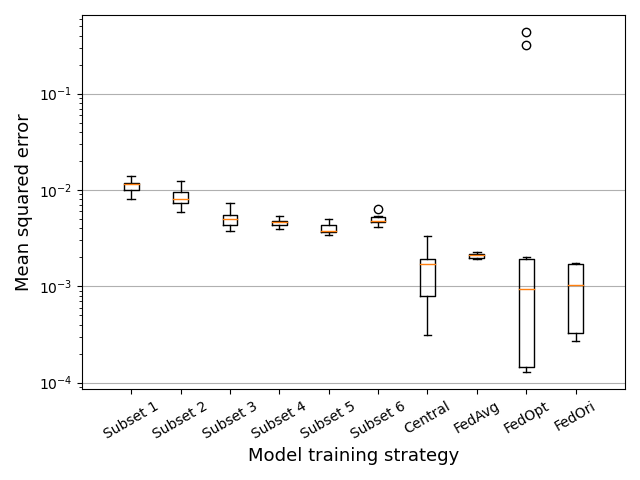

In [10]:
with open("federated_mse.pkl","rb") as f:
    m = pickle.load(f)

plt.figure()
plt.yscale("log")
for i in range(len(mse_subsets)):
    plt.boxplot(m["Subsets"]["mse_subsets"][i], labels = ["Subset "+str(i+1)], positions=[i/2])
    
plt.boxplot(m["Global"]["mse_global"], labels = ["Central"], positions = [(i+1)/2])
plt.boxplot(m["FedAvg"]["mse_federated"], labels = ["FedAvg"], positions = [(i+2)/2])
plt.boxplot(m["FedOpt"]["mse_federated"], labels = ["FedOpt"], positions = [(i+3)/2])
plt.boxplot(m["FedOpt_mirror"]["mse_federated"], labels = ["FedOri"], positions = [(i+4)/2])
plt.plot([0,6],[mse_xfoil,mse_xfoil])
plt.xlabel("Model training strategy", size = 13)
plt.ylabel("Mean squared error", size = 13)
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.tight_layout()
